# Natural Language Processing Demystified | Classification with Naive Bayes
https://nlpdemystified.org<br>
https://github.com/futuremojo/nlp-demystified
<br><br>
Course module for this demo: https://www.nlpdemystified.org/course/naive-bayes

# spaCy upgrade and package installation.

At the time this notebook was created, spaCy had newer releases but Colab was still using version 2.x by default. So the first step is to upgrade spaCy and download a statistical model for English.
<br><br>
**IMPORTANT**<br>
If you're running this in the cloud, then the notebook will *timeout* after a period of inactivity. If that happens and you don't reconnect in time, you will need to upgrade spaCy again and reinstall the requisite statistical package(s).
<br><br>
Refer to this link on how to run Colab notebooks locally on your machine to avoid this issue:<br>
https://research.google.com/colaboratory/local-runtimes.html

In [1]:
!pip install -U spacy==3.*
!python -m spacy download en_core_web_sm
!python -m spacy info

zsh:1: no matches found: spacy==3.*
/Users/justin/mambaforge/envs/nlp_env/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 314.2 kB/s eta 0:00:0000:0100:02
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
/Users/justin/mambaforge/envs/nlp_env/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"

============================== Info about spaCy ==============================

spaCy version    3.5.3                         
Location         /Users/justin/mambaforge/envs/nlp_env/lib/python3.10/site-packages/spacy

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy

from sklearn import metrics
from sklearn import model_selection
from sklearn.datasets import fetch_20newsgroups
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# First pass at building a Naive Bayes model.


As with our TF-IDF demo, we'll use the **20 newsgroups** dataset, a labelled dataset of 18,000 newsgroup posts across 20 topics.<br>
https://scikit-learn.org/stable/datasets/real_world.html#the-20-newsgroups-text-dataset

This time around, rather than fetching the posts from only one topic, we'll fetch the entire collection.

In [3]:
# To build our model, we want the training subset only. The training
# subset is what gets downloaded by default but we explicitly
# pass the parameter here for clarity.
training_corpus = fetch_20newsgroups(subset='train')

In [4]:
print('Training data size: {}'.format(len(training_corpus.data)))

Training data size: 11314


The training data we downloaded not only includes the posts but also a label ("target") for each post representing its topic. The posts are an array of strings while the labels are a corresponding array of numeric labels.

In [5]:
# These are the possible topics a post can belong to.
training_corpus.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [6]:
# These are the labels/targets for each post.
print(training_corpus.target)

[7 4 4 ... 3 1 8]


In [7]:
# The first post along with its corresponding label.
print(training_corpus.data[0])

first_doc_label = training_corpus.target[0]
print('Label for this post: {}'.format(first_doc_label))
print('Corresponding topic: {}'.format(training_corpus.target_names[first_doc_label]))

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----





Label for this post: 7
Corresponding topic: rec.autos


When starting off with a dataset, it's a good idea to check its distribution. In this case, we can see at a glance this dataset is relatively balanced.

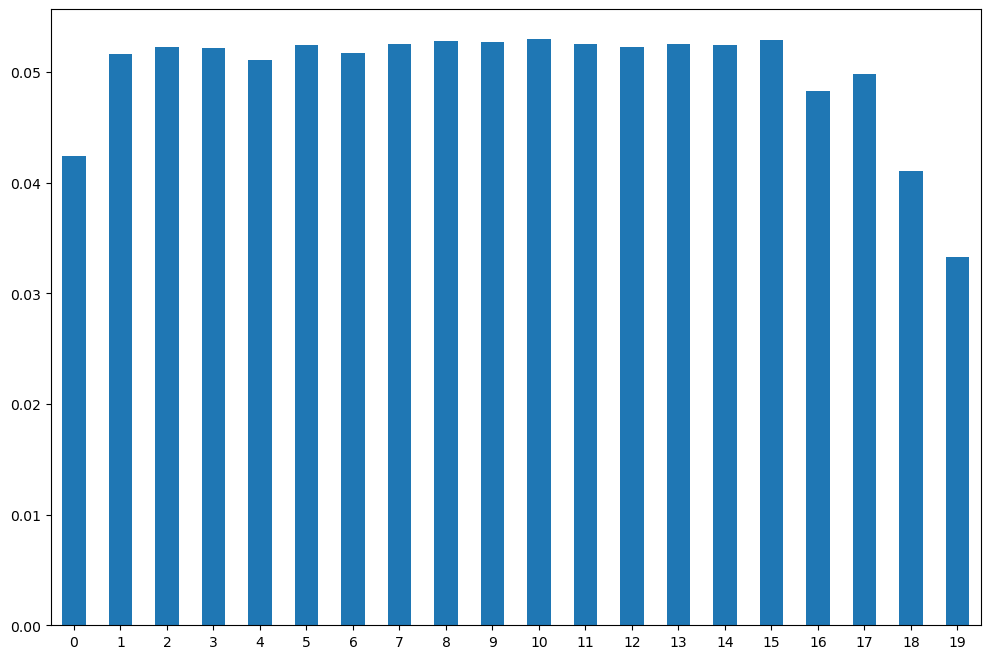

In [8]:
bins, counts = np.unique(training_corpus.target, return_counts=True)
freq_series = pd.Series(counts/len(training_corpus.data))
plt.figure(figsize=(12, 8))
ax = freq_series.plot(kind='bar')
ax.set_xticklabels(bins, rotation=0)
plt.show()

Now that we have our training set, we can split it further into train and validation sets (remember the test set, in this case, is a separate download). Creating a validation set isn't always necessary. If you have a small training set like this one, you can use alternative techniques like cross-validation but we'll show a split here since we talked about it in the model building module. scikit-learn has a module to help us do this.<br>
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [9]:
# Shuffle, then split the data into train and validation sets. Set the random_state
# to 1 for reproducibility.
train_data, val_data, train_labels, val_labels = train_test_split(training_corpus.data, training_corpus.target, train_size=0.8, random_state=1)
print('Training data size: {}'.format(len(train_data)))
print('Validation data size: {}'.format(len(val_data)))

Training data size: 9051
Validation data size: 2263


Now that we have our train-validation split, let's create our spaCy tokenizer. Up to this point, we've been using the **en_core_web_sm** model.

In [10]:
nlp = spacy.load('en_core_web_sm')

By default, it comes up with a preprocessing pipeline with several components enabled. We can view these components through the *pipe_names* attribute.

In [11]:
nlp.pipe_names

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

In the previous demos, we individually disabled any component we didn't need. For our first pass at building a Naive Bayes classifier, we'll try tokenizing alone. Nothing else. Since that's the case, it's easier to instantiate a blank pipeline.<br>
https://spacy.io/api/top-level#spacy.blank

In [12]:
nlp = spacy.blank('en')

# There should be no pipeline components.
nlp.pipe_names

[]

In [13]:
# For this exercise, we'll remove punctuation and spaces (which
# includes newlines), filter for tokens consisting of alphabetic
# characters only, and return the token text.
def spacy_tokenizer(doc):
  return [t.text for t in nlp(doc) if \
          not t.is_punct and \
          not t.is_space and \
          t.is_alpha]

We'll vectorize using the **TfidfVectorizer**.

In [15]:
%%time
vectorizer = TfidfVectorizer(tokenizer=spacy_tokenizer)
train_feature_vects = vectorizer.fit_transform(train_data)

CPU times: user 24.7 s, sys: 111 ms, total: 24.8 s
Wall time: 24.8 s


In [19]:
# The number of unique tokens.
print(len(vectorizer.get_feature_names_out()))

60536


In [18]:
train_feature_vects.shape

(9051, 60536)

Scikit-learn includes a multinomial naive bayes classifier.<br>
https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

Calling *fit* on the classifier and passing it the feature vectors and corresponding labels kicks off the training.

In [14]:
# Instantiate a classifier with the default settings.
nb_classifier = MultinomialNB()
nb_classifier.fit(train_feature_vects, train_labels)
nb_classifier.get_params()

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True}

Now that we know about the **F1 score** and have a multiclass problem, let's look at the F1 score on the training data. Since the dataset is balanced, accuracy could work here as well but we'll look at F1 since we introduced it. scikit-learn has a module called **metrics** we can leverage. It contains a variety of scoring utilities we can use.<br>
https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics<br>
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score<br>
https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics<br>

In [15]:
# Get predictions on training set and calculate F1 score.
# See documentation above for more details on what "macro" means.
train_preds = nb_classifier.predict(train_feature_vects)
print('F1 score on initial training set: {}'.format(metrics.f1_score(train_labels, train_preds, average='macro')))

F1 score on initial training set: 0.8982344792497875


So right off the bat, using simple preprocessing and vectorization, and the default settings on the Naive Bayes classifier, we get a model with a decent F1 score. This looks good, but there's a problem.<br><br>
When we downloaded the training data, we also included headers and footers which contain metadata like *subject*, and *email*.<br><br>
This can be a problem because these fields may be highly informative, causing the model to predict mostly based on the metadata rather than the post content. But if this metadata isn't available at prediction time in production, then our model is going to perform poorly.
<br><br>
So let's retrieve the training data again but without the headers, footers, and post quotes this time. Just raw post text. This makes the problem notably harder for reasons we'll see soon.

In [16]:
# Remove headers, footers, and quotes from training set and resplit.
filtered_training_corpus = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
train_data, val_data, train_labels, val_labels = train_test_split(filtered_training_corpus.data, filtered_training_corpus.target, train_size=0.8, random_state=1)

In [17]:
# This is what a data point looks like now. Just plain post text.
train_data[0]

"\nI don't know about that...I've used Photoshop 2.5 on both a 486dx-50 and a Quadra\n950...I'd say they are roughly equal.  If anything the 486 was faster."

In [25]:
%%time
# Revectorize our text and retrain our model.

train_feature_vects = vectorizer.fit_transform(train_data)
nb_classifier.fit(train_feature_vects, train_labels)

CPU times: user 6.69 s, sys: 51.6 ms, total: 6.74 s
Wall time: 6.78 s


MultinomialNB()

In [26]:
# Recheck F1 score on training data.
train_preds = nb_classifier.predict(train_feature_vects)
print('F1 score on filtered training set: {}'.format(metrics.f1_score(train_labels, train_preds, average='macro')))

F1 score on filtered training set: 0.791654644597863


Now that we've removed metadata, our F1 score has dropped but still seems ok. The next step is to see how well the classifier performs on the validation set.

In [27]:
%%time
# Vectorize the validation data.

val_feature_vects = vectorizer.transform(val_data)

CPU times: user 1.65 s, sys: 11.4 ms, total: 1.66 s
Wall time: 1.67 s


In [28]:
# Predict and evaluate.
val_preds = nb_classifier.predict(val_feature_vects)
print('F1 score on filtered validation set: {}'.format(metrics.f1_score(val_labels, val_preds, average='macro')))

F1 score on filtered validation set: 0.6087677070998413


That's quite a drop in F1 score. Because there are 20 classes involved, let's plot a confusion matrix to see what's going on:<br>
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html<br>
https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix

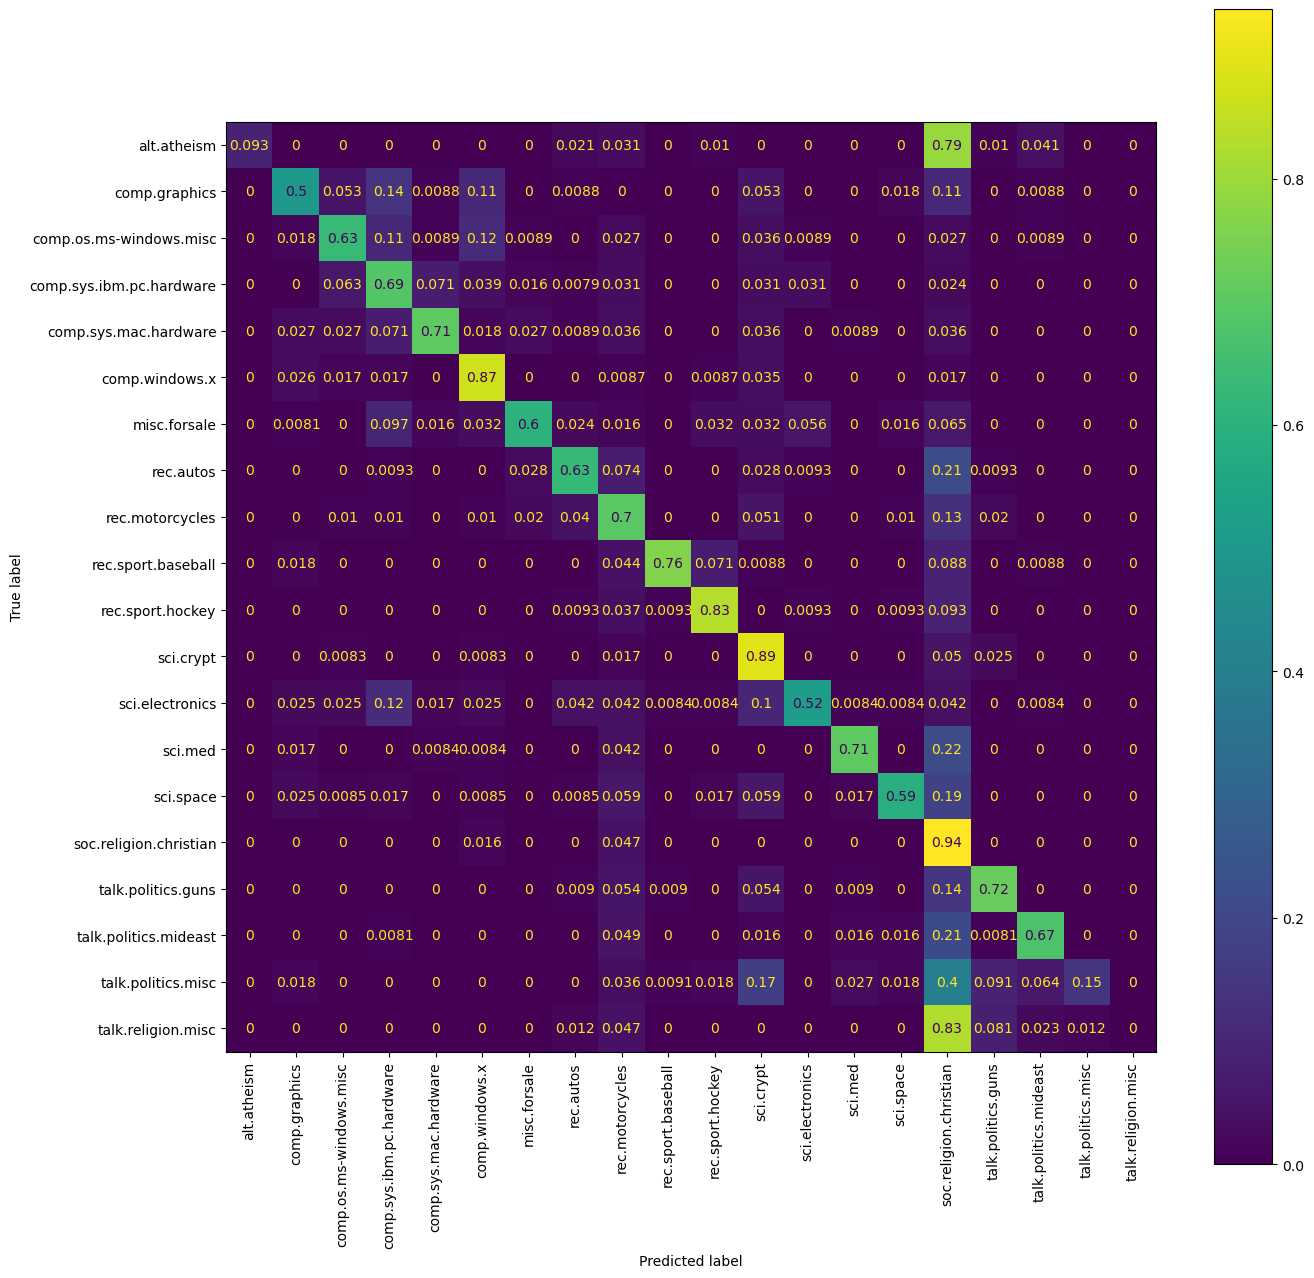

In [29]:
# Set the size of the plot.
fig, ax = plt.subplots(figsize=(15, 15))

# Create the confusion matrix.
disp = ConfusionMatrixDisplay.from_estimator(nb_classifier, val_feature_vects, val_labels, normalize='true', display_labels=filtered_training_corpus.target_names, xticks_rotation='vertical', ax=ax)

Similar to what we saw in the slides, the y-axis represents the true labels and the x-axis represents the predictions. Each square's brightness represents the number of posts assigned to that class. What we ideally want is brightness along the diagonal (top-left to bottom-right) which represent correct predictions, and little to no brightness anywhere else.
<br><br>
Looking at the confusion matrix above, we can make a few observations:
1. The more specific a topic is, the better the prediction result. Hockey and cryptography are good examples. This intuitively makes sense.
2. Topics with a lot of word overlap tend to have higher errors. For example, the majority of atheism and religion.misc posts are classified under christianity. In general, the christianity column has a prevalence of brighter squares with misclassified posts from politics.misc, politics.mideast, etc.
3. There's a smaller, secondary cluster of errors around the computer-related topics (e.g. posts in electronics being misclassified as hardware).
<br><br>
Seeing the results of this matrix, at least there are plausible explanations for the discrepancies.

Let's take a look at **precision** and **recall** for each label:<br>
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html<br>
https://scikit-learn.org/stable/modules/model_evaluation.html#classification-report

In [30]:
print(metrics.classification_report(val_labels, val_preds, target_names=filtered_training_corpus.target_names))

                          precision    recall  f1-score   support

             alt.atheism       1.00      0.09      0.17        97
           comp.graphics       0.73      0.50      0.59       114
 comp.os.ms-windows.misc       0.74      0.63      0.68       112
comp.sys.ibm.pc.hardware       0.56      0.69      0.61       127
   comp.sys.mac.hardware       0.83      0.71      0.76       112
          comp.windows.x       0.69      0.87      0.77       115
            misc.forsale       0.87      0.60      0.71       124
               rec.autos       0.76      0.63      0.69       108
         rec.motorcycles       0.47      0.70      0.56        99
      rec.sport.baseball       0.96      0.76      0.85       113
        rec.sport.hockey       0.83      0.83      0.83       108
               sci.crypt       0.57      0.89      0.69       120
         sci.electronics       0.82      0.52      0.64       119
                 sci.med       0.89      0.71      0.79       119
         

/Users/justin/mambaforge/envs/nlp_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/justin/mambaforge/envs/nlp_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/justin/mambaforge/envs/nlp_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

A few observations:
1. Atheism has a perfect precision score but terrible recall, signalling that the model was right when it classified something as under atheism, but missed the vast majority in the corpus. The model didn't classify anything under religion.misc.
2. The more specific the topic, the better it tends to do.

# Improving the model



Let's try to do better. One thing that's likely an issue is the sheer number of features we have relative to how little data there is.

In [31]:
print('Training data size: {}'.format(len(train_data)))
print('Number of training features: {}'.format(len(train_feature_vects[0].toarray().flatten())))

Training data size: 9051
Number of training features: 51637


So we can experiment with:
1. Removing stop words because topic identification likely depends more on keywords rather than sequences in this case.
3. Using the token lemma rather than the text.
<br>


We can't get away with the blank pipeline since we need a bunch of components to generate the lemma. So we'll load the **en_core_web_sm** model and disable named-entity recognition and parsing in the tokenizer callback.

In [32]:
nlp = spacy.load('en_core_web_sm')

In [33]:
unwanted_pipes = ['ner', 'parser']

# Further remove stop words and take the lemma instead of token text.
def spacy_tokenizer(doc):
  with nlp.disable_pipes(*unwanted_pipes):
    return [t.lemma_ for t in nlp(doc) if \
            not t.is_punct and \
            not t.is_space and \
            not t.is_stop and \
            t.is_alpha]

We need to re-vectorize the training set with the new tokenizer. Because there are certain components enabled, this is going to take longer (a few mins). Take a look at these link for ways to further optimize spaCy's pipeline:<br>
https://spacy.io/usage/processing-pipelines#processing<br>
https://spacy.io/api/language#pipe<br><br>
YouTube video from spaCy on using **nlp.pipe**: [Speed up spaCy pipelines via `nlp.pipe` - spaCy shorts](https://www.youtube.com/watch?v=OoZ-H_8vRnc)<br>
Tuning **nlp.pipe**: https://stackoverflow.com/questions/65850018/processing-text-with-spacy-nlp-pipe<br>
Passing a list of pre-processed tokens to TfidfVectorizer: https://www.davidsbatista.net/blog/2018/02/28/TfidfVectorizer/

In [34]:
%%time
vectorizer = TfidfVectorizer(tokenizer=spacy_tokenizer)
train_feature_vects = vectorizer.fit_transform(train_data)

CPU times: user 2min 7s, sys: 4.21 s, total: 2min 11s
Wall time: 2min 12s


In [35]:
# Check the number of features now.
print('Number of training features: {}'.format(len(train_feature_vects[0].toarray().flatten())))

Number of training features: 42714


A little better but still not great. Let's retrain our classifier and see what happens.

In [36]:
nb_classifier.fit(train_feature_vects, train_labels)
train_preds = nb_classifier.predict(train_feature_vects)
print('Training F1 score with fewer features: {}'.format(metrics.f1_score(train_labels, train_preds, average='macro')))

Training F1 score with fewer features: 0.8398883700432671


Check classifier performance on validation set.

In [37]:
%%time
val_feature_vects = vectorizer.transform(val_data)

CPU times: user 30.5 s, sys: 1.09 s, total: 31.6 s
Wall time: 31.8 s


In [38]:
val_preds = nb_classifier.predict(val_feature_vects)
print('Validation F1 score with fewer features: {}'.format(metrics.f1_score(val_labels, val_preds, average='macro')))

Validation F1 score with fewer features: 0.6723713085312655


We managed to squeeze out a few percentage points. Let's look at the confusion matrix and classification report.

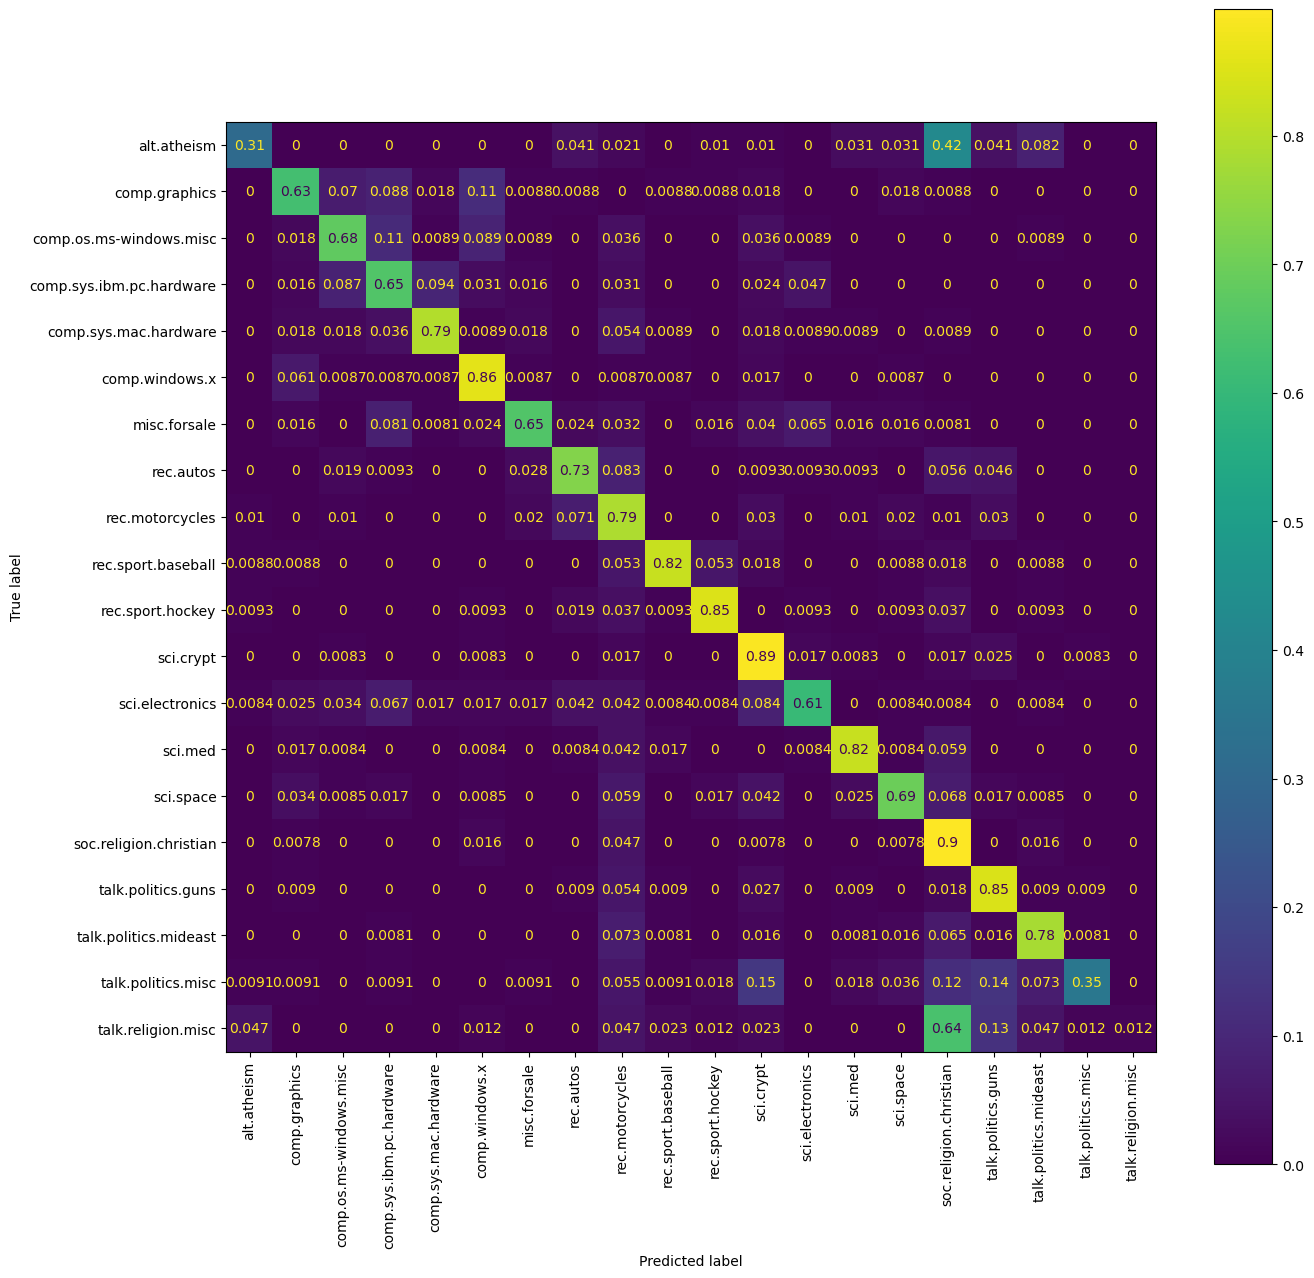

In [39]:
fig, ax = plt.subplots(figsize=(15, 15))
disp = ConfusionMatrixDisplay.from_estimator(nb_classifier, val_feature_vects, val_labels, normalize='true', display_labels=filtered_training_corpus.target_names, xticks_rotation='vertical', ax=ax)

In [40]:
print(metrics.classification_report(val_labels, val_preds, target_names=filtered_training_corpus.target_names))

                          precision    recall  f1-score   support

             alt.atheism       0.77      0.31      0.44        97
           comp.graphics       0.72      0.63      0.67       114
 comp.os.ms-windows.misc       0.70      0.68      0.69       112
comp.sys.ibm.pc.hardware       0.62      0.65      0.64       127
   comp.sys.mac.hardware       0.82      0.79      0.81       112
          comp.windows.x       0.71      0.86      0.78       115
            misc.forsale       0.84      0.65      0.74       124
               rec.autos       0.77      0.73      0.75       108
         rec.motorcycles       0.46      0.79      0.58        99
      rec.sport.baseball       0.89      0.82      0.85       113
        rec.sport.hockey       0.85      0.85      0.85       108
               sci.crypt       0.63      0.89      0.74       120
         sci.electronics       0.77      0.61      0.68       119
                 sci.med       0.86      0.82      0.84       119
         

In the confusion matrix, the squares in the christian column have dimmed, signalling fewer classification errors. And although atheism now classifies better, that topic along with religion.misc remain big sources of overall errors.

Let's assume for now that we can't get or generate more data.

Next, we can try tuning a hyperparameter on the classifier. For Naive Bayes, we'll adjust the the *alpha* smoothing factor we discussed in the slides. But rather than trying a bunch ourselves, we can use a combination of **Grid Search** and **Cross Validation**.
- Grid search involves having the computer try a list of hyperparameter values for us, and returning the best performing value. The list of hyperparameter values to try is supplied by us. Grid search is a basic technique and there are a number of other techniques such as **random search** and **bayesian optimization**.
- Cross validation is a way to evaluate machine learning models on limited datasets. It randomly splits the data into k-groups. One group is set aside as the holdout set while the classifier trains a model on the remaining groups. The resulting model is then used on the holdout group and the score recorded. This repeats itself until all groups have been used as a holdout set and an average score returned.

Scikit-learn has modules to handle both for us:<br>
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html<br>
https://scikit-learn.org/stable/modules/grid_search.html#grid-search<br>
https://scikit-learn.org/stable/modules/cross_validation.html<br>


In [41]:
# The alpha values to try.
params = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0,],}

# Instantiate the search with the model we want to try and fit it on the training data.
multinomial_nb_grid = model_selection.GridSearchCV(MultinomialNB(), param_grid=params, scoring='f1_macro', n_jobs=-1, cv=5, verbose=5)
multinomial_nb_grid.fit(train_feature_vects, train_labels)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 5/5] END ........................alpha=0.01;, score=0.764 total time=   0.1s
[CV 4/5] END .........................alpha=0.1;, score=0.733 total time=   0.1s
[CV 3/5] END .........................alpha=0.1;, score=0.712 total time=   0.1s
[CV 2/5] END .........................alpha=0.1;, score=0.731 total time=   0.1s
[CV 4/5] END ........................alpha=0.01;, score=0.743 total time=   0.1s
[CV 1/5] END .........................alpha=0.1;, score=0.718 total time=   0.1s
[CV 1/5] END ........................alpha=0.01;, score=0.740 total time=   0.1s
[CV 3/5] END ........................alpha=0.01;, score=0.727 total time=   0.1s
[CV 5/5] END .........................alpha=0.1;, score=0.743 total time=   0.1s
[CV 2/5] END ........................alpha=0.01;, score=0.740 total time=   0.1s
[CV 2/5] END .........................alpha=0.5;, score=0.703 total time=   0.0s
[CV 1/5] END .........................alpha=0.5;,

GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.1, 0.5, 1.0, 10.0]},
             scoring='f1_macro', verbose=5)

The resulting **GridSearchCV** object has a number of attributes you can explore:<br>
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
<br><br>
We're interested in the best performing parameter value(s).

In [42]:
print('Best parameter value(s): {}'.format(multinomial_nb_grid.best_params_))

Best parameter value(s): {'alpha': 0.01}


You can directly access the best estimator found by the search. Let's try using it on the validation set.

In [43]:
best_nb_classifier = multinomial_nb_grid.best_estimator_
val_preds = best_nb_classifier.predict(val_feature_vects)
print('Validation F1 score with fewer features: {}'.format(metrics.f1_score(val_labels, val_preds, average='macro')))

Validation F1 score with fewer features: 0.7321088520594417


So we got another decent jump after using the the optimal *alpha* value. Let's look at the confusion matrix (using the best estimator so far) and classification report again.


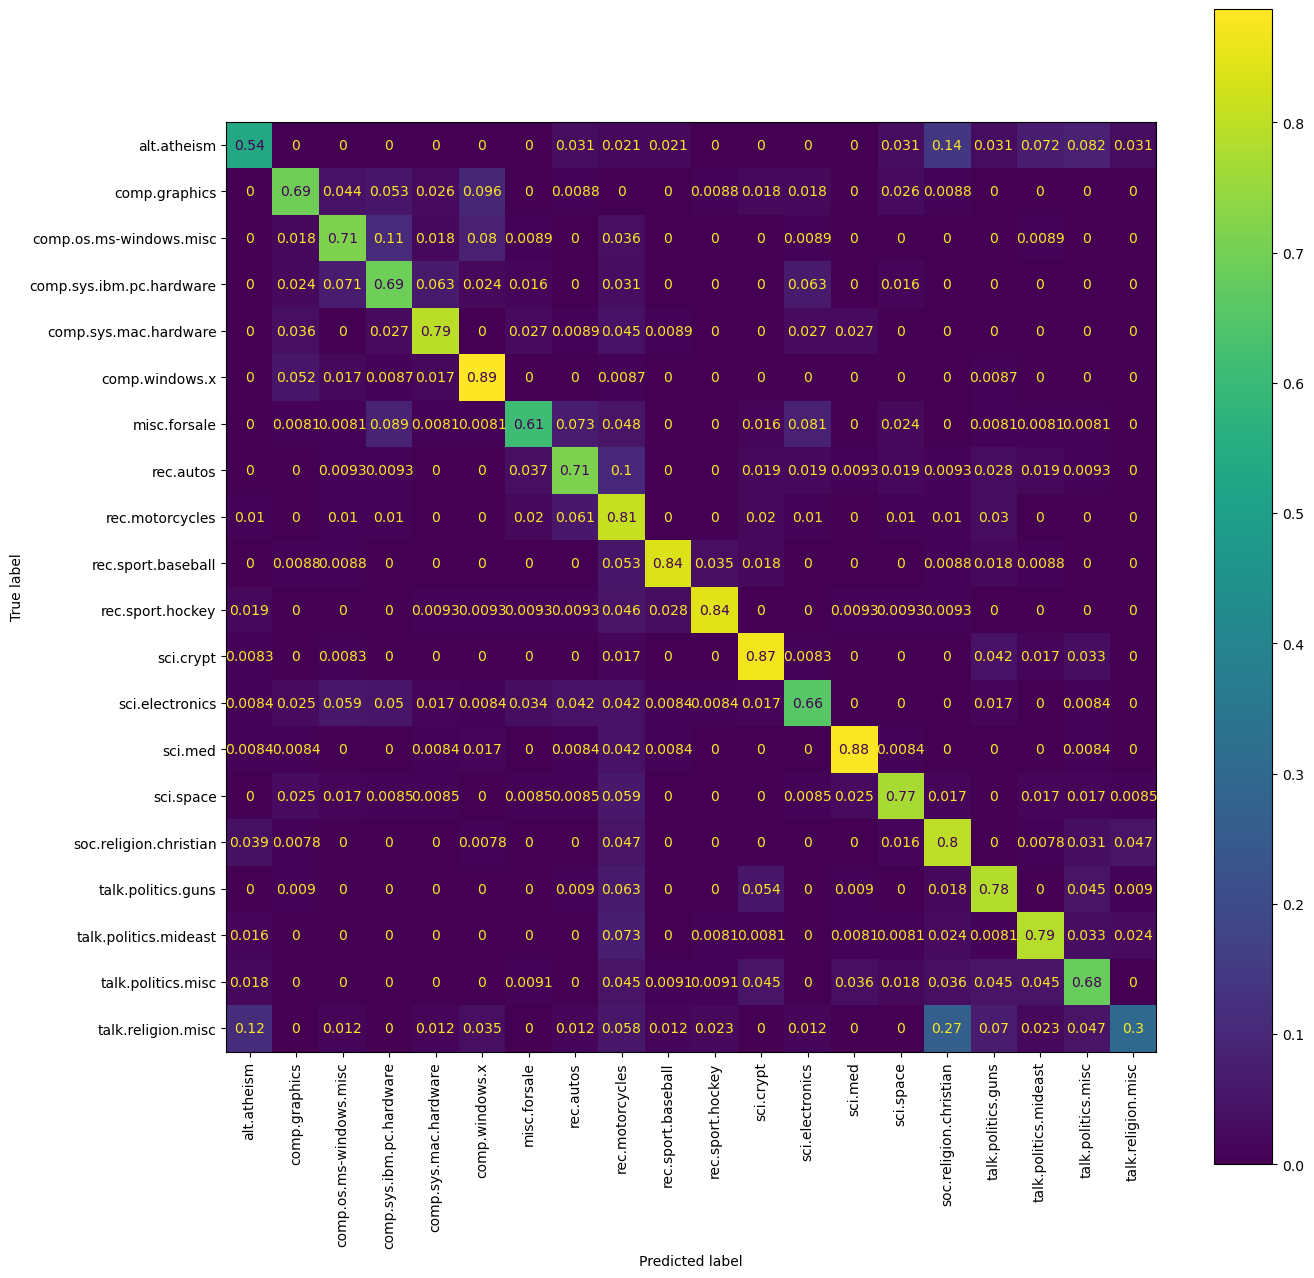

In [44]:
fig, ax = plt.subplots(figsize=(15, 15))
disp = ConfusionMatrixDisplay.from_estimator(best_nb_classifier, val_feature_vects, val_labels, normalize='true', display_labels=filtered_training_corpus.target_names, xticks_rotation='vertical', ax=ax)

In [45]:
print(metrics.classification_report(val_labels, val_preds, target_names=filtered_training_corpus.target_names))

                          precision    recall  f1-score   support

             alt.atheism       0.68      0.54      0.60        97
           comp.graphics       0.75      0.69      0.72       114
 comp.os.ms-windows.misc       0.72      0.71      0.72       112
comp.sys.ibm.pc.hardware       0.68      0.69      0.68       127
   comp.sys.mac.hardware       0.80      0.79      0.80       112
          comp.windows.x       0.76      0.89      0.82       115
            misc.forsale       0.80      0.61      0.69       124
               rec.autos       0.72      0.71      0.72       108
         rec.motorcycles       0.46      0.81      0.58        99
      rec.sport.baseball       0.90      0.84      0.87       113
        rec.sport.hockey       0.90      0.84      0.87       108
               sci.crypt       0.81      0.87      0.84       120
         sci.electronics       0.72      0.66      0.69       119
                 sci.med       0.88      0.88      0.88       119
         

A few observations from this one:
1. Atheism and religion.misc are doing much better though still a source of errors.
2. The christian column has dimmed further in the other categories.

Given the small data size and the soft borders around various topics, what we have now is probably good enough. A few further ideas to explore:
1. Augment the training data with posts from similar subreddits.
2. Incorporate n-grams.
3. Remove the *misc* categories if your goal allows it.
4. Merge a few categories with large overlap together if your goal allows it.
5. Use the **CountVectorizer** instead of the **TfidfVectorizer**.
6. Play around with adding more stop words after seeing which ones are the most prevalent.
7. Play with the min_df, max_df, and max_features in the **TFidfVectorizer**.
8. Use a dimensionality reduction technique like Singular Value Decomposition (SVD) or dense word vectors which we'll cover in Part II.
9. Try other models: logistic regression, support vector machines, random forests, SGD classifier.

My guess is that, aside from merging categories, it'll be hard to do much better than what we have given the nature of the data.

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
<br>
https://scikit-learn.org/stable/modules/svm.html#svm-classification
<br>
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
<br>
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html



For idea **(6)**, we can use the function below to view the most commonly occurring words in each category.

In [46]:
def show_top_words(classifier, vectorizer, categories, top_n):
  feature_names = np.asarray(vectorizer.get_feature_names_out())
  for i, category in enumerate(categories):
    prob_sorted = classifier.feature_log_prob_[i, :].argsort()[::-1]
    print("%s: %s" % (category, " ".join(feature_names[prob_sorted[:top_n]])))

In [47]:
show_top_words(best_nb_classifier, vectorizer, filtered_training_corpus.target_names, 10)

alt.atheism: god religion atheist people think say atheism post belief believe
comp.graphics: file graphic image thank program format look know color software
comp.os.ms-windows.misc: window file driver problem use program card do thank font
comp.sys.ibm.pc.hardware: drive card controller bus scsi monitor ide mb thank pc
comp.sys.mac.hardware: mac apple drive problem monitor card thank work simms quadra
comp.windows.x: x window server widget motif application use run thank program
misc.forsale: sale offer shipping sell price new include email condition drive
rec.autos: car engine drive like dealer good new buy oil look
rec.motorcycles: bike ride motorcycle dod helmet like rider go think know
rec.sport.baseball: game year team baseball hit win player run fan pitch
rec.sport.hockey: game team play hockey player season playoff nhl win year
sci.crypt: key encryption chip clipper government system nsa phone escrow bit
sci.electronics: power use circuit know like work chip ground try line
sc

As a sanity check, we can use scikit-learns **DummyClassifier** which can make predictions using strategies such as "just guess the most frequently occurring class" or "make random guesses".<br>
https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html

In [48]:
# Train a dummy classifier which just guesses the most frequent class.
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(train_feature_vects, train_labels)
dummy_clf.score(val_feature_vects, val_labels)

0.043747238179407864

In [49]:
# Train a dummy classifier which just guesses a class randomly.
dummy_clf = DummyClassifier(strategy="uniform")
dummy_clf.fit(train_feature_vects, train_labels)
dummy_clf.score(val_feature_vects, val_labels)

0.05700397702165267

# Creating the final Naive Bayes classifier.

Let's train the classifier we'll use on the test set. We'll use the entire original training set (including validation data) and the ideal *alpha* param.
<br>
We'll also use scikit-learn's **Pipeline** to specify a series of transformation and training steps so we can vectorize and fit a model with one call. Creating a few of these pipelines can help speed up your development and stay organized:<br>
https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html


In [54]:
nlp.pipe_names

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

In [55]:
unwanted_pipes = ['ner', 'parser']

# Further remove stop words and take the lemma instead of token text.
def spacy_tokenizer(doc):
  with nlp.disable_pipes(*unwanted_pipes):
    return [t.lemma_ for t in nlp(doc) if \
            not t.is_punct and \
            not t.is_space and \
            not t.is_stop and \
            t.is_alpha]

In [56]:
text_classifier = Pipeline([
  ('vectorizer', TfidfVectorizer(tokenizer=spacy_tokenizer)),
  ('classifier', MultinomialNB(alpha=0.01))
])

In [59]:
%%time
text_classifier.fit(filtered_training_corpus.data, filtered_training_corpus.target)

CPU times: user 2min 31s, sys: 5.05 s, total: 2min 36s
Wall time: 2min 37s


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function spacy_tokenizer at 0x28ff78e50>)),
                ('classifier', MultinomialNB(alpha=0.01))])

Download the 20 newsgroups *test* dataset.

In [60]:
filtered_test_corpus = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

We can now pass the raw test data directly to the classifier.

In [61]:
%%time
test_preds = text_classifier.predict(filtered_test_corpus.data)

CPU times: user 1min 35s, sys: 3.67 s, total: 1min 39s
Wall time: 1min 40s


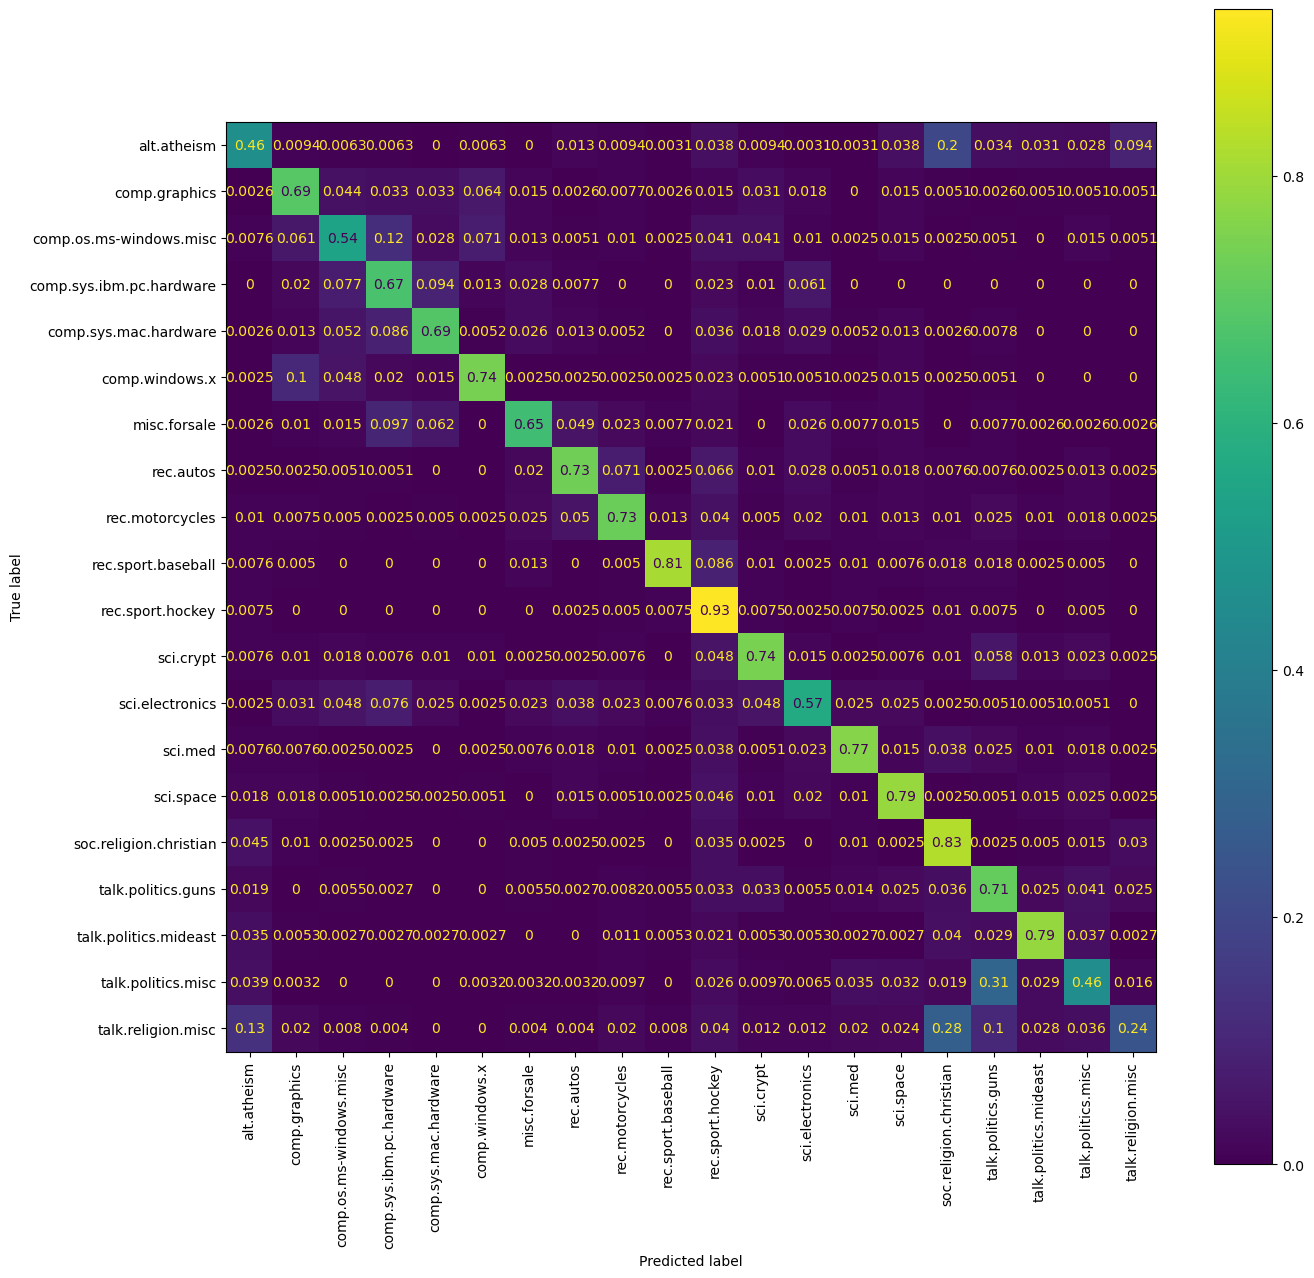

CPU times: user 853 ms, sys: 704 ms, total: 1.56 s
Wall time: 610 ms


In [62]:
%%time
fig, ax = plt.subplots(figsize=(15, 15))
ConfusionMatrixDisplay.from_predictions(filtered_test_corpus.target, test_preds, normalize='true', display_labels=filtered_test_corpus.target_names, xticks_rotation='vertical', ax=ax)
plt.show()

Looking at the confusion matrix for test data classification, we see there are still a few brighter clusters around the soft politics/religion area as well as the finer-grained computer-related topics which drag the overall accuracy down. This is reflected in the classification report as well. Overall, the other topics look ok given the data we have.
<br><br>

In [63]:
print(metrics.classification_report(filtered_test_corpus.target, test_preds, target_names=filtered_test_corpus.target_names))

                          precision    recall  f1-score   support

             alt.atheism       0.56      0.46      0.51       319
           comp.graphics       0.68      0.69      0.68       389
 comp.os.ms-windows.misc       0.62      0.54      0.58       394
comp.sys.ibm.pc.hardware       0.59      0.67      0.62       392
   comp.sys.mac.hardware       0.71      0.69      0.70       385
          comp.windows.x       0.80      0.74      0.77       395
            misc.forsale       0.77      0.65      0.70       390
               rec.autos       0.77      0.73      0.75       396
         rec.motorcycles       0.77      0.73      0.75       398
      rec.sport.baseball       0.92      0.81      0.86       397
        rec.sport.hockey       0.58      0.93      0.72       399
               sci.crypt       0.74      0.74      0.74       396
         sci.electronics       0.67      0.57      0.62       393
                 sci.med       0.83      0.77      0.80       396
         

We can now leverage our pipeline to classify new documents on the fly now.
<br><br>
The function below takes a classifier, a document to classify, and an optional set of labels. It returns a tuple of the most probable class and its probability. With this information, you can choose a probability threshold over which to accept a classification. If it falls below the threshold, perhaps you can classify it in some default bucket or pass it to a human, or to another classifier downstream. You could also require a minimum string length for classification along with other conditions.
<br><br>


In [64]:
def classify_text(clf, doc, labels=None):
  probas = clf.predict_proba([doc]).flatten()
  max_proba_idx = np.argmax(probas)

  if labels:
    most_proba_class = labels[max_proba_idx]
  else:
    most_proba_class = max_proba_idx

  return (most_proba_class, probas[max_proba_idx])

The strings below were taken at random from subreddits that have corresponding topics (e.g. r/space, r/cars, etc).

In [65]:
# Post from r/medicine.
s = "Hello everyone so am doing my thesis on Ischemic heart disease have been using online articles and textbooks mostly Harrisons internal med. could u recommended me some source specifically books where i can get more about in depth knowledge on IHD."
classify_text(text_classifier, s, filtered_test_corpus.target_names)

('sci.med', 0.7852448884156163)

In [66]:
# Post from r/space.
s = "First evidence that water can be created on the lunar surface by Earth's magnetosphere. Particles from Earth can seed the moon with water, implying that other planets could also contribute water to their satellites."
classify_text(text_classifier, s, filtered_test_corpus.target_names)

('sci.space', 0.967173327740258)

In [67]:
# Post from r/cars.
s = "New Toyota 86 Launch Reportedly Delayed to 2022, CEO Doesn't Want a Subaru Copy"
classify_text(text_classifier, s, filtered_test_corpus.target_names)

('rec.autos', 0.8448310429495018)

In [68]:
# Post from r/electronics.
s = "My First Ever Homemade PCB. My SMD Soldering Skills Aren't Great, But I'm Quite Proud of it."
classify_text(text_classifier, s, filtered_test_corpus.target_names)

('sci.electronics', 0.9253245234781562)

These are a few made-up statements with low probability which could belong to anything. In these situations, they can be dealt with as special cases.

In [69]:
s = "I don't know if that's a good idea."
classify_text(text_classifier, s, filtered_test_corpus.target_names)

('comp.sys.ibm.pc.hardware', 0.08070427273938324)

In [70]:
s = "Hold on for dear life."
classify_text(text_classifier, s, filtered_test_corpus.target_names)

('soc.religion.christian', 0.27552216141302194)

**Note:**<br>
Keep in mind that Naive Bayes is good at returning the most probable class but is regarded as a poor estimator because of its naive assumption of independence (i.e. the actual probability values aren't very reliable).